# Challenge 3
***

In [1]:
# Load the packages required to run this notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import scipy.stats as ss

%matplotlib inline

In [2]:
# Load the datasets
adventure_works = pd.read_csv('../adventure_works.csv', parse_dates = ['BirthDate'])

In [3]:
adventure_works.columns

Index(['CustomerID', 'FirstName', 'LastName', 'AddressLine1', 'City',
       'StateProvinceName', 'CountryRegionName', 'PostalCode', 'PhoneNumber',
       'BirthDate', 'Education', 'Occupation', 'Gender', 'MaritalStatus',
       'HomeOwnerFlag', 'NumberCarsOwned', 'NumberChildrenAtHome',
       'TotalChildren', 'YearlyIncome', 'AveMonthSpend', 'BikeBuyer', 'Age',
       'AgeGroup'],
      dtype='object')

In [4]:
# Drop columns with minimal predictive power and 'BikeBuyer' since we don't have that at the time of evaluation
adventure_works.drop(['CustomerID', 'FirstName', 'LastName', 'AddressLine1', 'PostalCode', 'PhoneNumber',
                      'BirthDate', 'BikeBuyer'], axis=1, inplace=True)

In [5]:
adventure_works.head()

,City,StateProvinceName,CountryRegionName,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,AveMonthSpend,Age,AgeGroup
0,Rockhampton,Queensland,Australia,Bachelors,Professional,M,M,1,0,0,2,137947,89,31,Between 25 and 45 years
1,Seaford,Victoria,Australia,Bachelors,Professional,M,S,0,1,3,3,101141,117,32,Between 25 and 45 years
2,Hobart,Tasmania,Australia,Bachelors,Professional,M,M,1,1,3,3,91945,123,32,Between 25 and 45 years
3,North Ryde,New South Wales,Australia,Bachelors,Professional,F,S,0,1,0,0,86688,50,29,Between 25 and 45 years
4,Wollongong,New South Wales,Australia,Bachelors,Professional,F,S,1,4,5,5,92771,95,29,Between 25 and 45 years


In [6]:
# Transform numeric features to make their distributions symmetric
adventure_works['SqrtYearlyIncome'] = np.sqrt(adventure_works['YearlyIncome'])
adventure_works['LogAveMonthSpend'] = np.log(adventure_works['AveMonthSpend'])

## Prepare data for scikit-learn model

In [7]:
# Create numpy array of label values
Labels = np.array(adventure_works['LogAveMonthSpend'])
Labels = Labels.reshape(Labels.shape[0],)

In [8]:
import warnings
warnings.filterwarnings('ignore')

# Create model matrix
def encode_string(cat_features):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

categorical_columns = ['Occupation', 'Gender', 'MaritalStatus', 'HomeOwnerFlag', 'AgeGroup', 
                       'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren']

Features = encode_string(adventure_works['Education'])
for col in categorical_columns:
    temp = encode_string(adventure_works[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])    

(16404, 37)
[[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [9]:
# Concatenate numeric features to model matrix
Features = np.concatenate([Features, np.array(adventure_works[['SqrtYearlyIncome']])], axis = 1)
print(Features.shape)
print(Features[:2, :])

(16404, 38)
[[  1.           0.           0.           0.           0.
    0.           0.           0.           1.           0.
    0.           1.           1.           0.           0.
    1.           1.           0.           0.           0.
    1.           0.           0.           0.           0.
    1.           0.           0.           0.           0.
    0.           0.           0.           1.           0.
    0.           0.         371.41216997]
 [  1.           0.           0.           0.           0.
    0.           0.           0.           1.           0.
    0.           1.           0.           1.           1.
    0.           1.           0.           0.           0.
    0.           1.           0.           0.           0.
    0.           0.           0.           1.           0.
    0.           0.           0.           0.           1.
    0.           0.         318.02672844]]


In [10]:
print(Features.shape)
print(Labels.shape)

(16404, 38)
(16404,)


# `Linear Regression Model`

In [11]:
## Randomly sample cases to create independent training and test data
nr.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 0.2)
X_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13123, 38)
(13123,)
(3281, 38)
(3281,)


In [13]:
# Scale numeric features
scaler = preprocessing.StandardScaler().fit(X_train[:,37:])
X_train[:,37:] = scaler.transform(X_train[:,37:])
X_test[:,37:] = scaler.transform(X_test[:,37:])
X_train[:2,]

array([[ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.70392457],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
   

In [14]:
## define and fit the linear regression model
lin_mod = linear_model.LinearRegression()
lin_mod.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
# Print model coefficients
print(lin_mod.intercept_)
print(lin_mod.coef_)

40355117652.43488
[ 3.89527920e+10  3.89527920e+10  3.89527920e+10  3.89527920e+10
  3.89527920e+10 -2.35047744e+10 -2.35047744e+10 -2.35047744e+10
 -2.35047744e+10 -2.35047744e+10 -1.51275455e+10 -1.51275455e+10
 -4.10799028e+10 -4.10799028e+10  9.10157498e+09  9.10157498e+09
 -2.68618120e+09 -2.68618120e+09 -2.68618121e+09 -2.68618120e+09
  2.47680251e+10  2.47680251e+10  2.47680251e+10  2.47680251e+10
  2.47680251e+10 -1.52562083e+10 -1.52562083e+10 -1.52562083e+10
 -1.52562083e+10 -1.52562083e+10 -1.52562083e+10 -1.55228976e+10
 -1.55228976e+10 -1.55228976e+10 -1.55228976e+10 -1.55228976e+10
 -1.55228976e+10  9.77062934e-02]


In [16]:
# Print several useful metrics for regression
def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
y_score = lin_mod.predict(X_test) 
print_metrics(y_test, y_score, 38)    

Mean Square Error      = 0.002709159190233819
Root Mean Square Error = 0.05204958395831632
Mean Absolute Error    = 0.03913959486736695
Median Absolute Error  = 0.03050577963759782
R^2                    = 0.977459137856707
Adjusted R^2           = 0.9772019648997838


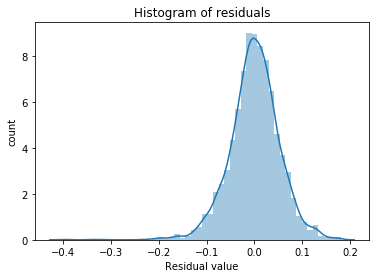

In [17]:
# Plot histogram of residuals
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, y_score)

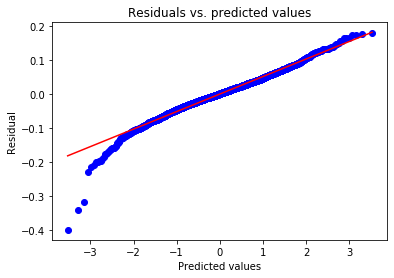

In [18]:
# Display Q-Q Normal plot
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    ss.probplot(resids.flatten(), plot = plt)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
resid_qq(y_test, y_score)

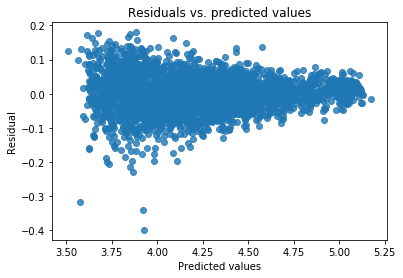

In [19]:
# Plot of residuals vs predicted values
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False)
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')

resid_plot(y_test, y_score) 

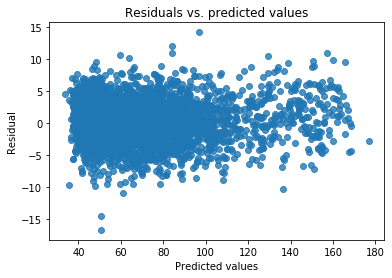

In [20]:
# Plot of residuals vs exp(predicted values) (Note: predictions are LogAvgMonthSpend)
y_score_untransform = np.exp(y_score)
y_test_untransform = np.exp(y_test)
resid_plot(y_test_untransform, y_score_untransform)

### Evaluating logistic regression model on AW_test.csv

In [21]:
evaluation = pd.read_csv('../Resources/AW_test.csv', parse_dates = ['BirthDate'])
evaluation.columns

Index(['CustomerID', 'Title', 'FirstName', 'MiddleName', 'LastName', 'Suffix',
       'AddressLine1', 'AddressLine2', 'City', 'StateProvinceName',
       'CountryRegionName', 'PostalCode', 'PhoneNumber', 'BirthDate',
       'Education', 'Occupation', 'Gender', 'MaritalStatus', 'HomeOwnerFlag',
       'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren',
       'YearlyIncome'],
      dtype='object')

In [22]:
# Prepare evaluation data for scikit-learn model
evaluation['Age'] = (pd.to_datetime("1998-01-01") - evaluation['BirthDate']) / np.timedelta64(1,'Y')
evaluation['Age'] = evaluation['Age'].astype('int64')

# Categorize customers in specific age groups
def age_group(row):
    if row['Age'] < 25:
        return "Under 25 years"
    if row['Age'] >= 25 and row['Age'] < 45:
        return "Between 25 and 45 years"
    if row['Age'] >= 45 and row['Age'] <= 55:
        return "Between 45 and 55 years"
    else:
        return "Over 55 years"

evaluation['AgeGroup'] = evaluation.apply(lambda row: age_group(row), axis=1)
evaluation['AgeGroup'].unique()

# Sqrt transform YearlyIncome values
evaluation['SqrtYearlyIncome'] = np.sqrt(evaluation['YearlyIncome'])

In [23]:
evaluation.drop(['CustomerID', 'Title', 'FirstName', 'MiddleName', 'LastName', 'Suffix', 'AddressLine1', 
                 'AddressLine2', 'City', 'StateProvinceName', 'CountryRegionName', 'PostalCode', 'PhoneNumber',
                 'BirthDate', 'Age'], axis=1, inplace=True)

In [24]:
evaluation.tail()

,Education,Occupation,Gender,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,AgeGroup,SqrtYearlyIncome
495,Graduate Degree,Skilled Manual,F,S,0,0,0,0,97084,Between 25 and 45 years,311.583055
496,Partial College,Management,F,S,0,4,4,4,110762,Between 45 and 55 years,332.809255
497,Bachelors,Management,F,S,0,4,3,3,138097,Over 55 years,371.614047
498,Partial College,Professional,F,M,1,1,0,2,101465,Between 25 and 45 years,318.535712
499,High School,Skilled Manual,F,S,0,2,0,4,19108,Between 45 and 55 years,138.231690


In [25]:
# Create model matrix for final evaluation on AW_test
categorical_columns = ['Occupation', 'Gender', 'MaritalStatus', 'HomeOwnerFlag', 'AgeGroup', 
                       'NumberCarsOwned', 'NumberChildrenAtHome', 'TotalChildren']

AW_test = encode_string(evaluation['Education'])
for col in categorical_columns:
    temp = encode_string(evaluation[col])
    AW_test = np.concatenate([AW_test, temp], axis = 1)

# Concatenate numeric features to model matrix
AW_test = np.concatenate([AW_test, np.array(evaluation[['SqrtYearlyIncome']])], axis = 1)
# Scale numeric features using same scalar object for train data
AW_test[:,37:] = scaler.transform(AW_test[:,37:])

In [26]:
# Compute predictions on AW_test and exponentiate predicted LogAvgMonthSpend values to bring back to original scale
predictions = lin_mod.predict(AW_test)
predictions = np.exp(predictions)
print(pd.DataFrame(predictions))
# pd.DataFrame(predictions).to_csv('challenge3_predictions.csv', sep = '\n', index = False, header = False)

# Note: 3.117595749 RMSE on AW_test

              0
0     46.884841
1    109.805166
2     47.666790
3     86.257450
4     57.378805
..          ...
495   50.398430
496   81.539283
497   70.196398
498   55.240471
499   37.903958

[500 rows x 1 columns]
